In [6]:
# Course : CS 513 - Knowledge Discovery and Data Mining
# Group Members: Branden Bulatao, Joseph Faustino, Natalie Fortes, Isabel Sutedjo
# Id : 20005971, 20006114, 20006007, 20006618
# Purpose : Music Happiness Predictor - Predicts the happiness of music tracks based on various features.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Load dataset
df = pd.read_csv('./dataset.csv')

# Drop unnamed and nulls
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df.dropna(inplace=True)

# Convert valence to binary: 0 = sad, 1 = happy
df['valence'] = df['valence'].map(lambda x: 0 if x < 0.5 else 1)

# Convert 'explicit' to int
df['explicit'] = df['explicit'].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['key', 'time_signature', 'track_genre'], drop_first=True)

# Define target and drop non-feature columns
y = df['valence']
X = df.drop(columns=['track_id', 'artists', 'album_name', 'track_name', 'valence', 'duration_ms'])

# Identify numeric features to scale
numeric_features = ['popularity', 'loudness', 'tempo']

# All other features (binary or one-hot) are left as-is
non_scaled_features = [col for col in X.columns if col not in numeric_features]

# ColumnTransformer for selective scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('pass', 'passthrough', non_scaled_features)
    ]
)

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

# Reconstruct a DataFrame (optional, for inspection/debugging)
X_processed = pd.DataFrame(X_processed, columns=numeric_features + non_scaled_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)
X_processed

,popularity,loudness,tempo,explicit,danceability,energy,mode,speechiness,acousticness,instrumentalness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,0.73,0.791392,0.361245,0,0.676,0.461,0,0.143,0.0322,0.000001,...,False,False,False,False,False,False,False,False,False,False
1,0.55,0.597377,0.318397,0,0.42,0.166,1,0.0763,0.924,0.000006,...,False,False,False,False,False,False,False,False,False,False
2,0.57,0.736123,0.313643,0,0.438,0.359,1,0.0557,0.21,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0.71,0.573701,0.746758,0,0.266,0.0596,1,0.0363,0.905,0.000071,...,False,False,False,False,False,False,False,False,False,False
4,0.82,0.737103,0.492863,0,0.618,0.443,1,0.0526,0.469,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113994,0.21,0.612952,0.517705,0,0.172,0.235,1,0.0422,0.64,0.928,...,False,False,False,False,False,False,False,False,False,True
113995,0.22,0.577345,0.350242,0,0.174,0.117,0,0.0401,0.994,0.976,...,False,False,False,False,False,False,False,False,False,True
113996,0.22,0.714648,0.543933,0,0.629,0.329,0,0.042,0.867,0.0,...,False,False,False,False,False,False,False,False,False,True
113997,0.41,0.714759,0.558651,0,0.587,0.506,1,0.0297,0.381,0.0,...,False,False,False,False,False,False,False,False,False,True


In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_linear = SGDClassifier(loss='hinge', max_iter=1000, class_weight='balanced', random_state=42)
svm_linear.fit(X_train, y_train)

svm_linear.fit(X_train, y_train)
y_pred = svm_linear.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: \n{accuracy * 100:.2f}%\n")

report = classification_report(y_test, y_pred)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(report)

print("Confusion Matrix:")
print(cm)

Accuracy: 
77.01%

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79     18571
           1       0.74      0.76      0.75     15629

    accuracy                           0.77     34200
   macro avg       0.77      0.77      0.77     34200
weighted avg       0.77      0.77      0.77     34200

Confusion Matrix:
[[14486  4085]
 [ 3779 11850]]


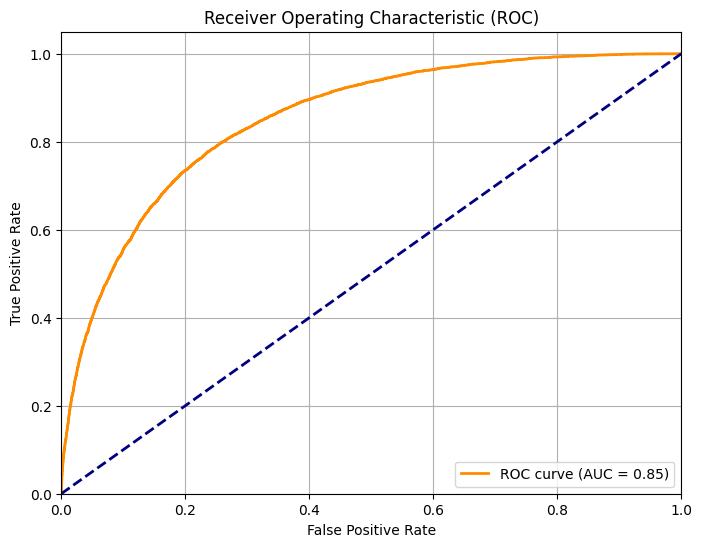

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_scores = svm_linear.decision_function(X_test)  # Decision function scores

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


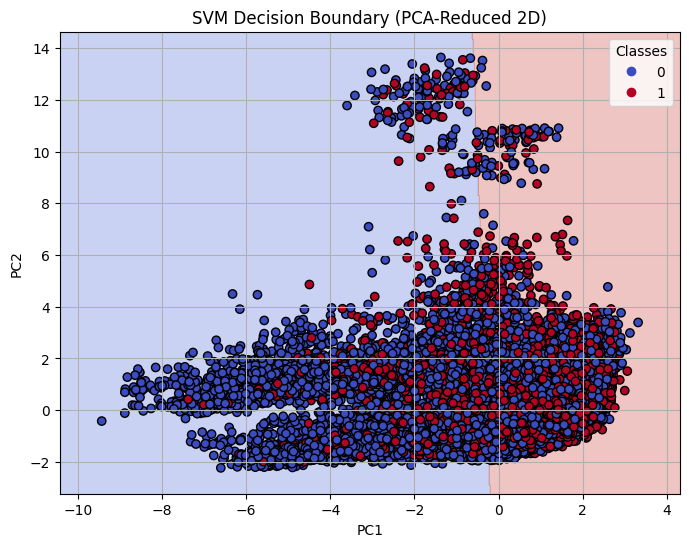

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features before PCA and model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reduce to 2D with PCA for visualization
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_scaled)
X_test_2D = pca.transform(X_test_scaled)

# Retrain model on reduced features
svm_2D = SGDClassifier(loss='hinge', max_iter=1000, class_weight='balanced', random_state=42)
svm_2D.fit(X_train_2D, y_train)

# Plotting
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in mesh

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("SVM Decision Boundary (PCA-Reduced 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

# Plot
plot_decision_boundary(svm_2D, X_test_2D, y_test)


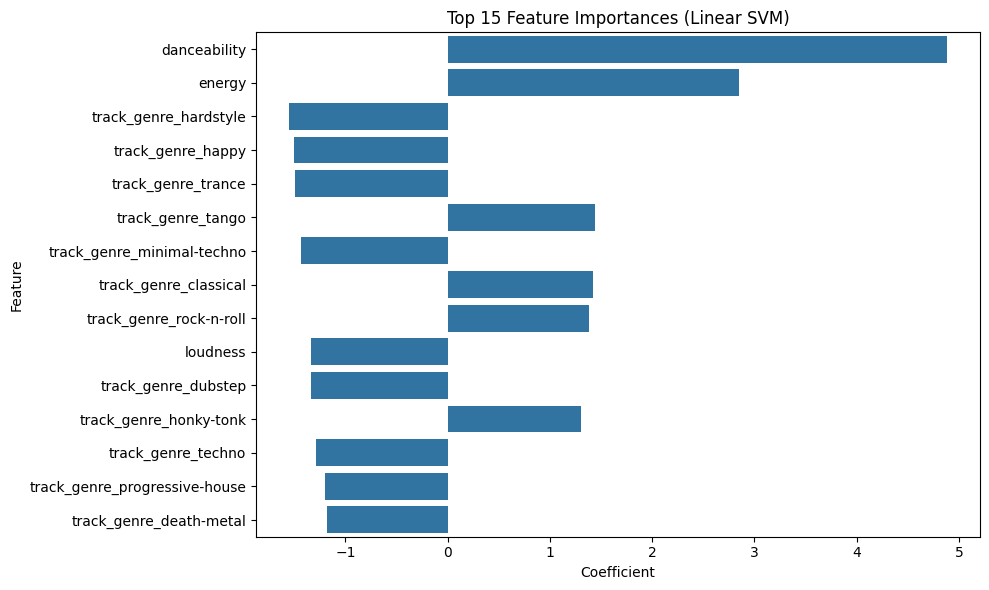

In [4]:
import numpy as np
import seaborn as sns

feature_names = X_train.columns  # or manually define if using a NumPy array
coefs = svm_linear.coef_[0]  # for binary classification

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(15))
plt.title("Top 15 Feature Importances (Linear SVM)")
plt.tight_layout()
plt.show()


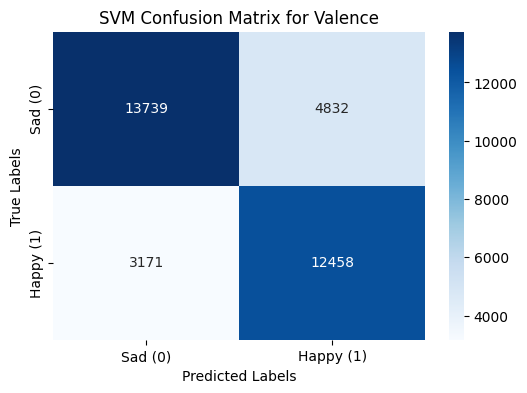

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the heatmap
plt.figure(figsize=(6, 4))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", ax=ax)

# Labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("SVM Confusion Matrix for Valence")
ax.xaxis.set_ticklabels(["Sad (0)", "Happy (1)"])
ax.yaxis.set_ticklabels(["Sad (0)", "Happy (1)"])

plt.show()